# Heat pipe modeling

This notebook embedd a dynamiclumped model of heat pipes.

## Goal

Solve the temperature transient of an heat pipe with different fluids. Plot the reults.

## Approach

1) read the thermophysical properties of the fluid and other parameters
2) Fitting data point as function of temperature
3) read heat pipe geometry file
4) read the initial condition file
5) Solve the system dynamic
6) plot the results

## Required tools

Pandas for reading files 

numpy for curve fitting (polynomial)

scipy for ode integration

matplotlib for visualisation

### Step 1: Import data with pandas

In [1]:
import pandas as pd

In [2]:
filename_fluid = "water.xlsx" #Change here the fluid

thermophys_data = pd.ExcelFile(filename_fluid)
print(type(thermophys_data))

thermophys_data = thermophys_data.parse("Sheet1") #overwrite to get a DataFrame
print(type(thermophys_data))

thermophys_data

<class 'pandas.io.excel._base.ExcelFile'>
<class 'pandas.core.frame.DataFrame'>


,Temperature (K),Saturation pressure (Pa),Latent heat (kJ/kg),Liquid density (kg/m3),Vapor density (kg/m3),Liquid viscosity (N-s/m2),Vapor viscosity (N-s/m2),Liquid thermal conductivity (W/m-K),Vapor thermal conductivity (W/m-K),Liquid surface tension (N/m),Liquid specific heat (kJ/kg-K),Vapor specific heat (kJ/kg-K)
0,308.00,2336.8,2453.8,999.00,0.01729,0.001002,0.000009,0.602,0.0188,0.07288,4.182,1.874
1,313.15,7374.9,2406.5,993.05,0.05110,0.000651,0.000010,0.630,0.0201,0.06948,4.179,1.894
2,333.15,19919.0,2358.4,983.28,0.13020,0.000463,0.000010,0.653,0.0216,0.06607,4.185,1.924
3,353.15,47359.0,2308.9,971.82,0.29320,0.000351,0.000011,0.669,0.0231,0.06269,4.197,1.969
4,373.15,101325.0,2251.2,958.77,0.59740,0.000279,0.000012,0.680,0.0248,0.05891,4.216,2.034
5,393.15,198540.0,2202.9,943.39,1.12100,0.000230,0.000013,0.685,0.0267,0.05496,4.245,2.124
6,413.15,361360.0,2144.9,925.93,1.96560,0.000195,0.000013,0.687,0.0288,0.05079,4.285,2.245
7,433.15,618040.0,2082.2,907.44,3.25890,0.000169,0.000014,0.684,0.0313,0.04651,4.339,2.406
8,453.15,1002700.0,2014.0,887.31,5.15970,0.000149,0.000015,0.676,0.0341,0.04219,4.408,2.615
9,473.15,1555100.0,1939.0,865.05,7.86530,0.000134,0.000016,0.664,0.0375,0.03777,4.497,2.883


In [3]:
filename_cooler = "water.xlsx" #Change here the fluid

thermophys_cooler_data = pd.ExcelFile(filename_fluid)
print(type(thermophys_data))

thermophys_cooler_data = thermophys_cooler_data.parse("Sheet1") #overwrite to get a DataFrame
print(type(thermophys_cooler_data))

thermophys_cooler_data

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,Temperature (K),Saturation pressure (Pa),Latent heat (kJ/kg),Liquid density (kg/m3),Vapor density (kg/m3),Liquid viscosity (N-s/m2),Vapor viscosity (N-s/m2),Liquid thermal conductivity (W/m-K),Vapor thermal conductivity (W/m-K),Liquid surface tension (N/m),Liquid specific heat (kJ/kg-K),Vapor specific heat (kJ/kg-K)
0,308.00,2336.8,2453.8,999.00,0.01729,0.001002,0.000009,0.602,0.0188,0.07288,4.182,1.874
1,313.15,7374.9,2406.5,993.05,0.05110,0.000651,0.000010,0.630,0.0201,0.06948,4.179,1.894
2,333.15,19919.0,2358.4,983.28,0.13020,0.000463,0.000010,0.653,0.0216,0.06607,4.185,1.924
3,353.15,47359.0,2308.9,971.82,0.29320,0.000351,0.000011,0.669,0.0231,0.06269,4.197,1.969
4,373.15,101325.0,2251.2,958.77,0.59740,0.000279,0.000012,0.680,0.0248,0.05891,4.216,2.034
5,393.15,198540.0,2202.9,943.39,1.12100,0.000230,0.000013,0.685,0.0267,0.05496,4.245,2.124
6,413.15,361360.0,2144.9,925.93,1.96560,0.000195,0.000013,0.687,0.0288,0.05079,4.285,2.245
7,433.15,618040.0,2082.2,907.44,3.25890,0.000169,0.000014,0.684,0.0313,0.04651,4.339,2.406
8,453.15,1002700.0,2014.0,887.31,5.15970,0.000149,0.000015,0.676,0.0341,0.04219,4.408,2.615
9,473.15,1555100.0,1939.0,865.05,7.86530,0.000134,0.000016,0.664,0.0375,0.03777,4.497,2.883


In [4]:
filename_hp = "heat_pipe_specs.xlsx" #heat pipe data specification

hp_data = pd.ExcelFile(filename_hp)
print(type(hp_data))

hp_data = hp_data.parse("Sheet1") #overwrite to get a DataFrame
print(type(hp_data))

hp_data

<class 'pandas.io.excel._base.ExcelFile'>
<class 'pandas.core.frame.DataFrame'>


,evaporator length (m),adiabatic length (m),condenser length (m),pipe external diameter (m),pipe internal diameter (m),wick internal diameter (m),wick permeability,wick porosity,wick effective porosity,cavity radius (m),wick heat capacity (J/kg-K),wick thermal conductivity (W/m-K),wick density (kg/m3),pipe heat capacity (J/kg-K),pipe thermal conductivity (W/m-K),pipe density (kg/m3)
0,0.6,0.09,0.2,0.0191,0.0188,0.0173,1.500000e-09,0.9,0.5,0.000024,380,390,8920,380,390,8920


In [5]:
filename_par = "parameters.xlsx" #thermal parameters specification

parameters_data = pd.ExcelFile(filename_par)
print(type(hp_data))

parameters_data = parameters_data.parse("Sheet1") #overwrite to get a DataFrame
print(type(parameters_data))

parameters_data

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,input power (W),htc (W/m2-K),cooling fluid temperature (K)
0,515,1800,273


## Fit of fluid thermophysical properties

In [6]:
import numpy as np
from numpy.polynomial import Polynomial
from scipy import interpolate


#extract data from DataFrame to arrays

temperature_for_fit = thermophys_data["Temperature (K)"] #get the dataframe slice
temperature_for_fit = temperature_for_fit.values #get only the values

#print(temperature_for_fit)

poly_deg = 4 #degree of the polynomial


#Fit all the required parameters

#pressure_for_fit = thermophys_data["Saturation pressure (Pa)"].values
#p_sat = Polynomial.fit(temperature_for_fit, pressure_for_fit,poly_deg) #note that np.polyfit is now legacy



latentheat_for_fit = thermophys_data["Latent heat (kJ/kg)"].values
hlv_sat = Polynomial.fit(temperature_for_fit, latentheat_for_fit,poly_deg) 
#hlv_sat = interpolate.interp1d(temperature_for_fit, latentheat_for_fit,kind = "linear") 

liquiddensity_for_fit = thermophys_data["Liquid density (kg/m3)"].values
rhol_sat = Polynomial.fit(temperature_for_fit, liquiddensity_for_fit,poly_deg) 
#rhol_sat =  interpolate.interp1d(temperature_for_fit, liquiddensity_for_fit,kind = "linear") 

vapordensity_for_fit = thermophys_data["Liquid density (kg/m3)"].values
rhov_sat = Polynomial.fit(temperature_for_fit, vapordensity_for_fit,poly_deg) 
#rhov_sat = interpolate.interp1d(temperature_for_fit, vapordensity_for_fit,kind= "linear") 

liquidviscosity_for_fit = thermophys_data["Liquid viscosity (N-s/m2)"].values
mul_sat = Polynomial.fit(temperature_for_fit, liquidviscosity_for_fit,poly_deg) 
#mul_sat = interpolate.interp1d(temperature_for_fit, liquidviscosity_for_fit,kind = "linear") 

vaporviscosity_for_fit = thermophys_data["Vapor viscosity (N-s/m2)"].values
muv_sat = Polynomial.fit(temperature_for_fit, vaporviscosity_for_fit,poly_deg) 
#muv_sat = interpolate.interp1d(temperature_for_fit, vaporviscosity_for_fit,kind="linear") 

liquidconductivity_for_fit = thermophys_data["Liquid thermal conductivity (W/m-K)"].values
kl_sat = Polynomial.fit(temperature_for_fit, liquidconductivity_for_fit,poly_deg) 
#kl_sat = interpolate.interp1d(temperature_for_fit, liquidconductivity_for_fit,kind="linear")

liquidtension_for_fit = thermophys_data["Liquid surface tension (N/m)"].values
sigma_sat = Polynomial.fit(temperature_for_fit, liquidtension_for_fit,poly_deg) 
#sigma_sat = interpolate.interp1d(temperature_for_fit, liquidtension_for_fit,kind = "linear")

liquidcapacity_for_fit = thermophys_data["Liquid specific heat (kJ/kg-K)"].values*1e3
cl_sat = Polynomial.fit(temperature_for_fit, liquidcapacity_for_fit,poly_deg) 
#cpl_sat = interpolate.interp1d(temperature_for_fit, liquidtension_for_fit,kind = "linear") 


temperature_for_plot = np.linspace(temperature_for_fit[0],temperature_for_fit[-1], 20)

### Polt the interpolation function to see the correctness

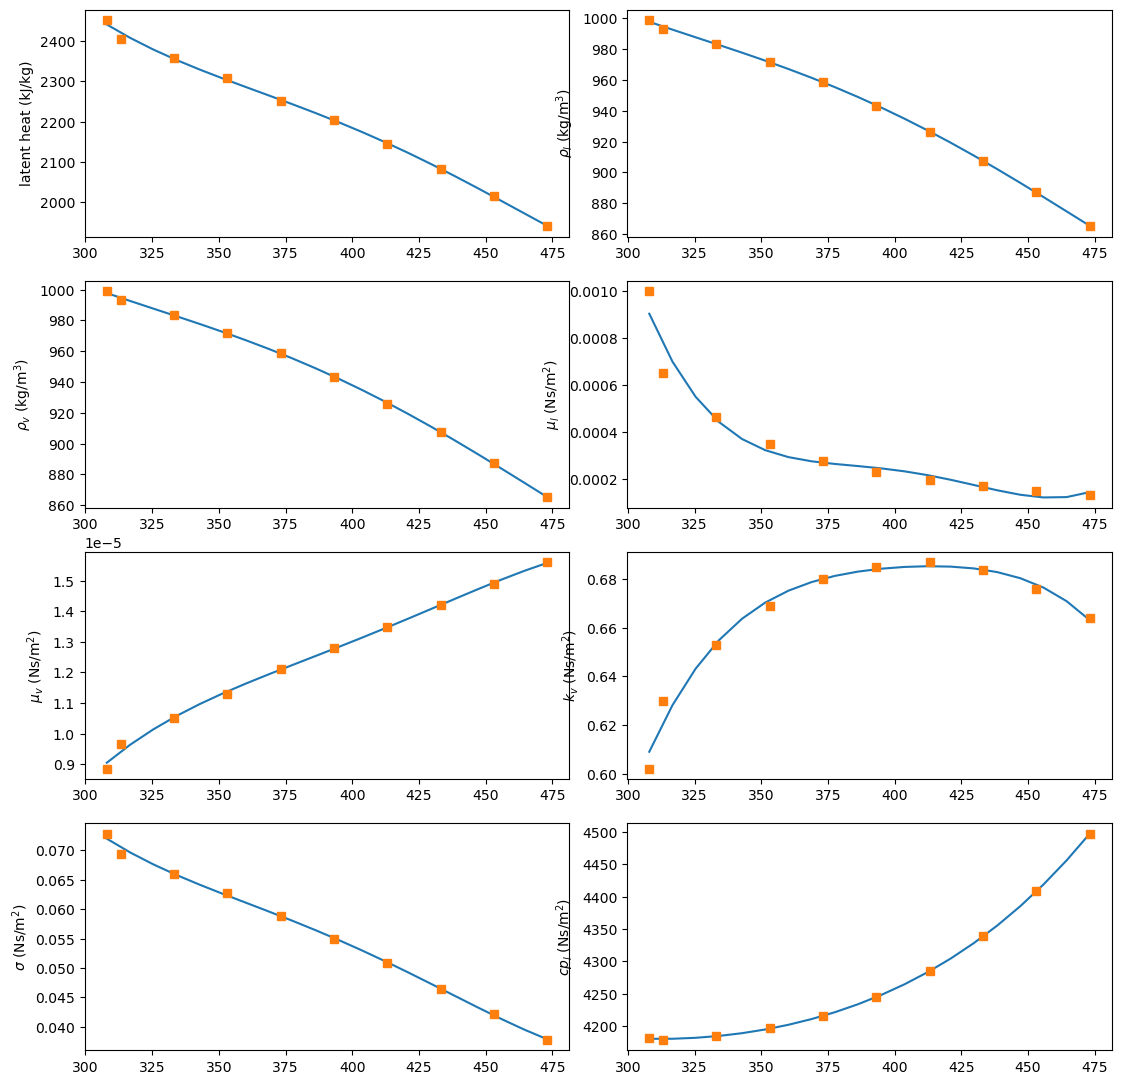

In [7]:
import matplotlib.pyplot as plt


#create subplots

fig, axs = plt.subplots(4,2, figsize = (11,11))
fig.tight_layout() #djust space between subplots, minimize overlap

axs[0,0].plot(temperature_for_plot,hlv_sat(temperature_for_plot))
axs[0,0].plot(temperature_for_fit,latentheat_for_fit, linestyle = "none", marker = "s")
axs[0,0].set_ylabel("latent heat (kJ/kg)")

axs[0,1].plot(temperature_for_plot,rhol_sat(temperature_for_plot))
axs[0,1].plot(temperature_for_fit,liquiddensity_for_fit, linestyle = "none", marker = "s")
axs[0,1].set_ylabel("$\u03C1_l$ (kg/m$^3$)")

axs[1,0].plot(temperature_for_plot,rhov_sat(temperature_for_plot))
axs[1,0].plot(temperature_for_fit,vapordensity_for_fit, linestyle = "none", marker = "s")
axs[1,0].set_ylabel("$\u03C1_v$ (kg/m$^3$)")

axs[1,1].plot(temperature_for_plot,mul_sat(temperature_for_plot))
axs[1,1].plot(temperature_for_fit,liquidviscosity_for_fit, linestyle = "none", marker = "s")
axs[1,1].set_ylabel("$\mu_l$ (Ns/m$^2$)")

axs[2,0].plot(temperature_for_plot,muv_sat(temperature_for_plot))
axs[2,0].plot(temperature_for_fit,vaporviscosity_for_fit, linestyle = "none", marker = "s")
axs[2,0].set_ylabel("$\mu_v$ (Ns/m$^2$)")

axs[2,1].plot(temperature_for_plot,kl_sat(temperature_for_plot))
axs[2,1].plot(temperature_for_fit,liquidconductivity_for_fit, linestyle = "none", marker = "s")
axs[2,1].set_ylabel("$k_v$ (Ns/m$^2$)")

axs[3,0].plot(temperature_for_plot,sigma_sat(temperature_for_plot))
axs[3,0].plot(temperature_for_fit,liquidtension_for_fit, linestyle = "none", marker = "s")
axs[3,0].set_ylabel("$\sigma$ (Ns/m$^2$)")

axs[3,1].plot(temperature_for_plot,cl_sat(temperature_for_plot))
axs[3,1].plot(temperature_for_fit,liquidcapacity_for_fit, linestyle = "none", marker = "s")
axs[3,1].set_ylabel("$cp_l$ (Ns/m$^2$)")

axs[3,0].ticklabel_format(style="sci", axis = "y")
axs[3,1].ticklabel_format(style="sci", axis = "y")

axs[2,0].ticklabel_format(style="sci", axis = "y")
axs[2,1].ticklabel_format(style="sci", axis = "y")

axs[1,0].ticklabel_format(style="sci", axis = "y")
axs[1,1].ticklabel_format(style="sci", axis = "y")

axs[0,0].ticklabel_format(style="sci", axis = "y")
axs[0,1].ticklabel_format(style="sci", axis = "y")

### Definition of some constants and variables

In [8]:
R = 8.314/(18e-3) #perfect gas reduced constant
gamma = 1.33      #cp/cv


#SOLID PROPERTIES
rhop = float(hp_data["pipe density (kg/m3)"].values)    #kg/m3
kp = float(hp_data["pipe thermal conductivity (W/m-K)"].values)  #W/mK
cp = float(hp_data["pipe heat capacity (J/kg-K)"].values)       #J/kg/K

rhow0 = float(hp_data["wick density (kg/m3)"].values)     #kg/m3
kw0 = float(hp_data["wick thermal conductivity (W/m-K)"].values)     #kg/m3
cp0 = float(hp_data["wick heat capacity (J/kg-K)"].values)     #kg/m3




#HP SPECS
dep = float(hp_data["pipe external diameter (m)"].values)
dip = float(hp_data["pipe internal diameter (m)"].values)
diw = float(hp_data["wick internal diameter (m)"].values)

Leva = float(hp_data["evaporator length (m)"].values)
La = float(hp_data["adiabatic length (m)"].values)
Lcond = float(hp_data["condenser length (m)"].values)

epsilon = float(hp_data["wick porosity"].values)
epsilon_eff = float(hp_data["wick effective porosity"].values)     #kg/m3
rc = float(hp_data["cavity radius (m)"].values)
K = float(hp_data["wick permeability"].values)

#compute cooling area in condenser
Af = Lcond*2*np.pi*(dep/2)  #condenser outer surface (cooling)
hf = float(parameters_data["htc (W/m2-K)"].values)


#VOLUMES
Vc = Lcond*np.pi*diw**2/4
Ve = Leva*np.pi*diw**2/4

#effective length
Leff = Leva/6 + La + Lcond/6

#INPUT POWER
Qin = float(parameters_data["input power (W)"].values)

#COOLING PART (assumed water)
Tf = float(parameters_data["cooling fluid temperature (K)"].values)
muf = float(thermophys_cooler_data["Liquid viscosity (N-s/m2)"].values[0])
kf = float(thermophys_cooler_data["Liquid thermal conductivity (W/m-K)"].values[0])
cf = float(thermophys_cooler_data["Liquid specific heat (kJ/kg-K)"].values[0]*1e3)








### Call for initial conditions

In [9]:

T0 = 273.17+20

#INITIAL CONDITIONS
Mle_0 = rhol_sat(T0)*epsilon*Leva*np.pi*(dip**2 - diw**2)/4
Mla_0 = rhol_sat(T0)*epsilon*Lcond*np.pi*(dip**2 - diw**2)/4
pve0 = T0*R*rhov_sat(T0)#0.023360e5
pva0 = T0*R*rhov_sat(T0)#0.023360e5
#T0*R*rhova
y0 = [T0,T0,T0,T0,T0,T0,0,pve0,pva0,T0,T0,Mle_0,Mla_0]

#float conversion is required otherwise the list is a mix between scalars and arrays



### Creation of the numerical model


In [17]:
from scipy.integrate import solve_ivp





def hp_model1(t,y):
    
    
    #y vector
    Tpe = y[0] #pipe evaporator temperature
    Tpc = y[1] #pipe condenser temperature
    Twe = y[2] #wick evaporator temperature
    Twc = y[3] #wick condenser temperature
    Tpa = y[4] #pipe adiabatic temperature
    Twa = y[5] #wick adiabatic temperature
    mdotv = y[6] #vapor mass flow rate
    Pve = y[7] #vapor pressure evaporator region
    Pvc = y[8] #vapor pressure condenser region
    Tve = y[9] #vapor evaporator temperature
    Tvc = y[10] #vapor condenser temperature
    Mle = y[11] #liquid mass in evaporator
    Mlc = y[12] #liquid mass in condenser

    
    
    #wrapped screen wick effective thermal conductivity
    
    kle = kl_sat(Twe)
    klc = kl_sat(Twc)
    kla = kl_sat(Twa)
    
    
    kwe = kle*((kle+kw0) - (1-epsilon_eff)*(kle-kw0))/((kle+kw0)+(1-epsilon_eff)*(kle-kw0))
    kwc = klc*((klc+kw0) - (1-epsilon_eff)*(klc-kw0))/((klc+kw0)+(1-epsilon_eff)*(klc-kw0))
    kwa = klc*((kla+kw0) - (1-epsilon_eff)*(kla-kw0))/((kla+kw0)+(1-epsilon_eff)*(kla-kw0))
    
    
    #thermophysical prop in the three regions
    mule = mul_sat(Twe)
    mula = mul_sat(Twa)
    muva = (muv_sat(Tve) + muv_sat(Tvc))/2
    
    rhole = rhol_sat(Twe)
    rhola = rhol_sat(Twa)
    rholc = rhol_sat(Twc)
    rhova = (rhov_sat(Twe) + rhov_sat(Twc))/2
    
    #THERMAL RESISTANCES
    #radial resistance
    R1pe = np.log(dep/(dip+dep)*2)/(2*np.pi*kp*Leva) #(dip+dep)/2 average diameter
    R2pe = np.log((dip+dep)/2/dip)/(2*np.pi*kp*Leva)
    R1we = np.log(dip/(diw+dip)*2)/(2*np.pi*kwe*Leva)
    R2we = np.log((diw+dip)/2/diw)/(2*np.pi*kwe*Leva)
    R1pc = np.log(dep/(dip+dep)*2)/(2*np.pi*kp*Lcond)
    R2pc = np.log((diw+dip)/2/diw)/(2*np.pi*kp*Lcond)
    R1wc = np.log(dep/(dip+dep)*2)/(2*np.pi*kwc*Lcond)
    R2wc = np.log((diw+dip)/2/diw)/(2*np.pi*kwc*Lcond)
    Rf = 1/hf/Af #external cooling resistance

    #axial resistances
    #which is the length?
    R1pa = 2*(Leva+La)/2/kp/(np.pi*(dep**2-dip**2)/4)#np.log(dep/(dip+dep)*2)/(2*np.pi*kp*La)
    R2pa = 2*(La+Lcond)/2/kp/(np.pi*(dep**2-dip**2)/4)#np.log((dip+dep)/2/dip)/(2*np.pi*kp*La)
    R1wa = 2*(Leva+La)/2/kwa/(np.pi*(dip**2-diw**2)/4)#np.log(dip/(diw+dip)*2)/(2*np.pi*kw*La)
    R2wa = 2*(La+Lcond)/2/kwa/(np.pi*(dip**2-diw**2)/4)#np.log((diw+dip)/2/diw)/(2*np.pi*kw*La)
    

    cle = cl_sat(Twe) 
    clc = cl_sat(Twc) 
    cla = cl_sat(Twa) 

    Cpe  = rhop*cp*(Leva*np.pi*(dep**2-dip**2)/4)
    Cwe  = ((rhop*cp)*(1-epsilon)+(rhole*cle)*epsilon)*(Leva*np.pi*(dip**2-diw**2)/4)
    Cpa  = rhop*cp*(La*np.pi*(dep**2-dip**2)/4)
    Cwa  = ((rhop*cp)*(1-epsilon)+(rhola*cla)*epsilon)*(La*np.pi*(dip**2-diw**2)/4)
    Cpc  = rhop*cp*(Lcond*np.pi*(dep**2-dip**2)/4)
    Cwc  = ((rhop*cp)*(1-epsilon)+(rholc*clc)*epsilon)*(Lcond*np.pi*(dip**2-diw**2)/4)

    

    
    
    Lva  = Leff/(np.pi*diw**2/4)
    Rle  = mule*Leva/(K*rhole*epsilon*np.pi*(dip**2-diw**2)/4)
    Rla  = mula/(K*rhola*epsilon*np.pi*(dip**2-diw**2)/4)
    Rva  = 8*muva*Leff/(rhova*np.pi*diw**2/4)
    
    
    hlv = hlv_sat(Twe)
    sigmaa = sigma_sat(Twa)
    sigmae = sigma_sat(Twe)
    sigmac = sigma_sat(Twc)
    sigma = np.mean([sigmaa,sigmae,sigmac])
    
    #UPDATE VAPOR CAPACITIES
    Cvc  = Vc/gamma/R/Tvc
    Cve  = Ve/gamma/R/Tve


    #Qin = -(Tpe-Teva)/R1pe
    

    #qin = 5
    if Mle <= Mle_0:
        f = -(Mle/Mle_0)+1
    else: 
        f = (Pve-Pvc)/(2*sigma/rc)
    


    dydt = [
        Qin/Cpe - (Tpe - Tpa)/R1pa/Cpe - (Tpe-Twe)/(R2pe+R1we)/Cpe,
        -(Tpc-Tpa)/R2pa/Cpc - (Tpc-Twc)/(R2pc+R1wc)/Cpc - (Tpc-Tf)/(R1pc+Rf)/Cpc,
        -(Twe -Twa)/R2wa/Cwe + (Tpe-Twe)/(R2pe+R1we)/Cwe - (Twe-Tve)/R2we/Cwe,
        -(Twc-Twa)/R2wa/Cwc + (Tpc-Twc)/(R2pc+R1wc)/Cwc - (Twc-Tvc)/R2wc/Cwc,
        -(Tpa-Tpe)/R1pa/Cpa - (Tpa-Tpc)/R2pa/Cpa,
        -(Twa-Twe)/R1wa/Cwa - (Twa-Twc)/R2wa/Cwa,
        Rva/Lva*mdotv + Pve/Lva - Pvc/Lva,
        (Twe-Tve)/Cve/R2we/hlv - mdotv/Cve ,
        mdotv/Cvc + (Twc-Tvc)/R2wc/hlv/Cvc,
        (gamma-1)/gamma*Tve/Pve*((Twe-Tve)/Cve/R2we/hlv - mdotv/Cve),
        (gamma-1)/gamma*Tvc/Pvc*(mdotv/Cvc + (Twc-Tvc)/R2wc/hlv/Cvc),
        #-(Twe-Tve)/R2we/hlv,
        + (Pvc-Pve)/Rva + 2*sigma*f/Rva/rc-(Twe-Tve)/R2we/hlv,\
        - (Pvc-Pve)/Rva - 2*sigma*f/Rva/rc-(Twc-Tvc)/R2wc/hlv]#-(Twc-Tvc)/R2wc/hlv]#-(Pvc-Pve)/Rva - 2*sigma*f/Rva/rc]
        

    return dydt

    
    



### Solve the model

In [18]:
#TIME SPAN
tt = [0,500]

#SOLVE THE MODEL
solution = solve_ivp(hp_model1,t_span = tt, y0 = y0 ,method='BDF')

#hp_model1(0,y0)

#SAVE THE SOLUTION
t = solution.t
y = solution.y

### Plotting the results

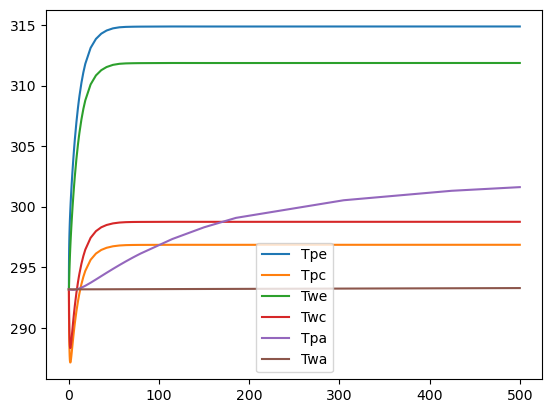

In [22]:
plt.plot(t,y[0],label="Tpe")
plt.plot(t,y[1],label="Tpc")
plt.plot(t,y[2],label="Twe")
plt.plot(t,y[3],label="Twc")
plt.plot(t,y[4],label="Tpa")
plt.plot(t,y[5],label="Twa")

plt.legend()